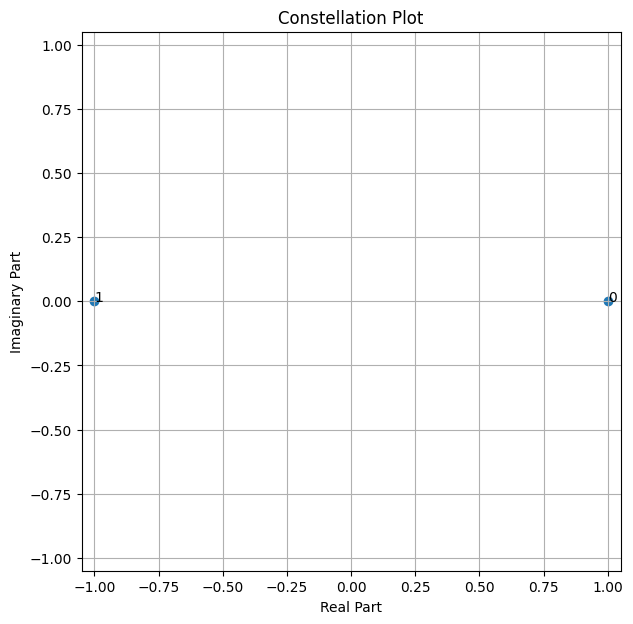

In [7]:
import sionna
import numpy as np
import tensorflow as tf

batch_size = 1000 # Number of symbols we want to generate
num_bits_per_symbol = 1 # 16-QAM has four bits per symbol
binary_source = sionna.phy.mapping.BinarySource()
b = binary_source([batch_size, num_bits_per_symbol])
# constellation = sionna.phy.mapping.Constellation("custom", num_bits_per_symbol,points=[-1+0j, 1+0j], normalize=True)
constellation = sionna.phy.mapping.Constellation("pam", num_bits_per_symbol)
constellation.show();

In [ ]:
# Opcion 2: canal satelital Lutz

# Parámetros del modelo Lutz (simplificado)
states = ["LOS", "Shadowed", "Blocked"]
attenuations_db = [0, 6, 20]  # Atenuación típica para cada estado (en dB)
state_probs = [0.7, 0.2, 0.1]  # Probabilidad de cada estado

def lutz_channel(x, state_probs, attenuations_db):
    # Selecciona un estado para cada símbolo
    state_idx = np.random.choice(len(state_probs), size=x.shape[1], p=state_probs)
    att_db = np.array(attenuations_db)[state_idx]
    att_lin = 10 ** (-att_db / 20)
    # Aplica la atenuación y añade ruido gaussiano
    noise = tf.complex(
        tf.random.normal(x.shape, stddev=0.1),
        tf.random.normal(x.shape, stddev=0.1)
    )
    y = x * att_lin + noise
    return y

# Uso del canal Lutz
y_lutz = lutz_channel(x, state_probs, attenuations_db)

# Visualiza la señal recibida
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
plt.scatter(np.real(y_lutz), np.imag(y_lutz))
ax.set_aspect("equal", adjustable="box")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginaria")
plt.grid(True, which="both", axis="both")
plt.title("Símbolos Recibidos (Canal Lutz)")